# Disney Email Data Analysis


### <font color='blue'>Data Analysis for Visualization</font>
    - One-Way Anova and Tukey comparing Platforms to Total Subscriptions and Streams Watched (for slide 6)
        - Tukey by Platform and Total Streams Watched
        - Tukey by Platform and Total Subscriptions
        
### <font color='blue'>Recommender Model to Reduce Churn for ESPN+</font>

    - Correlation between First and Second Streamed Titles and Total Subscriptions (slide 10)
         - 7 Day Conversion Group
        - 10 Day Conversion Group
        
    - Correlation between First and Second Stream Sports and Total Subscriptions (slides 11 & 12)
         - 7 Day Conversion Group
        - 10 Day Conversion Group
        
<font color='red'><b>NOTE:</b></font> for slides 7-9, see analysis [HERE](https://drive.google.com/file/d/1q4SXy99r1LPkTUMNbWayOco4jEjJRrfP/view?usp=sharing)

# Data Analysis for Visualization

In [2]:
import pandas as pd
import numpy as np
import time
import pandas as ps
import pandasql as ps
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

Start by connecting to Snowflake via API

In [3]:
import snowflake.connector

ctx = snowflake.connector.connect(
    user='<USER>',
    authenticator='externalbrowser',
    account='disneystreaming.us-east-1',
    warehouse='<WAREHOUSE>',
    database='<DATABASE>',
    schema='<SCHEMA>'
    )

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


Run subscription query containing subscriptions from Disney+ monthly to yearly with upsell email exposure.

In [4]:
import pandas as pd

sql = """ with monthly as (
    select distinct m.swid
                    , s.account_id
                    , s.subscription_source_provider as platform_monthly
                    , s.product_name as product_monthly
                    , s.calculated_subscription_start_dtm as sub_start_monthly
                    , s.calculated_subscription_end_dtm as sub_end_monthly
from dss_prod.dss.subscription s
inner join DSS_PROD.DSS.SFMC_ACCOUNT_SWID_MAP m on m.account_id = s.account_id
where s.is_bundle = 0
and s.partner = 'disney'
and lower(s.product_name) like '%monthly%'),

yearly as (
    select distinct m.swid
                    , s.account_id
                    , s.subscription_source_provider as platform_yearly
                    , s.product_name as product_yearly
                    , s.calculated_subscription_start_dtm as sub_start_yearly
                    , s.calculated_subscription_end_dtm as sub_end_yearly
from dss_prod.dss.subscription s
inner join DSS_PROD.DSS.SFMC_ACCOUNT_SWID_MAP m on m.account_id = s.account_id
where s.is_bundle = 0
and s.partner = 'disney'
and lower(s.product_name) like '%yearly%'),

email as (
          select distinct sl.swid
                , max(sc.eventdate) as last_click_dtm
                , max(sj.senttime) as senttime
                , count(sl.emailname) as total_emails
from DSS_PROD.DSS.SFMC_SENDLOG_DISNEY sl
inner join DSS_PROD.DSS.SFMC_TRACKING_EXTRACT_SENDJOBS sj on sj.sendid = sl.jobid
inner join DSS_PROD.DSS.CLARAVINE_DISNEY_EMAIL c on c.qsp_id = sl.claravine
left join (select distinct emailaddress, sendid, eventdate
            from DSS_PROD.DSS.SFMC_TRACKING_EXTRACT_CLICKS 
            where eventdate > '2020-07-27 00:00:00') sc on sc.sendid = sl.jobid and sc.emailaddress = sl.emailaddr
where c.campaign_focus in ('Upsell','Upgrade','Bundle_Upgrade')
and sl.emailname is not null
and sj.senttime > '2020-07-27 00:00:00'
and sj.senttime < sc.eventdate
group by 1),

m2yr as (
       select distinct mo.swid
       , mo.account_id
       , mo.platform_monthly
       , yr.platform_yearly
       , mo.product_monthly
       , yr.product_yearly
       , mo.sub_start_monthly
       , yr.sub_start_yearly
       , datediff(day, mo.sub_start_monthly, yr.sub_start_yearly) as sub_start_diff_days
       , mo.sub_end_monthly
       , yr.sub_end_yearly
       
from monthly mo
inner join yearly yr on mo.swid = yr.swid),

s2e as (
        select distinct my.swid
       , my.account_id
       , my.platform_monthly
       , my.platform_yearly
       , my.product_monthly
       , my.product_yearly
       , my.sub_start_monthly
       , my.sub_start_yearly
       , my.sub_start_diff_days
       , my.sub_end_monthly
       , my.sub_end_yearly
       , e.total_emails
       , e.senttime
       , e.last_click_dtm

from m2yr my
left join email e on my.swid = e.swid
where my.sub_start_yearly > my.sub_start_monthly
and my.sub_start_monthly < e.last_click_dtm
and e.last_click_dtm < my.sub_start_yearly),

final as (
       select distinct my2.swid
       , my2.account_id
       , my2.platform_monthly
       , my2.platform_yearly
       , my2.product_monthly
       , my2.product_yearly
       , my2.sub_start_monthly
       , my2.sub_start_yearly
       , case when my2.sub_start_diff_days between 0 and 50 then '001-050'
              when my2.sub_start_diff_days between 51 and 100 then '051-100'
              when my2.sub_start_diff_days between 101 and 150 then '101-150'
              when my2.sub_start_diff_days between 151 and 200 then '151-200'
              when my2.sub_start_diff_days between 201 and 250 then '201-250'
              when my2.sub_start_diff_days between 251 and 300 then '251-300'
              when my2.sub_start_diff_days between 301 and 350 then '301-350'
              when my2.sub_start_diff_days between 351 and 400 then '351-400'
              when my2.sub_start_diff_days between 401 and 450 then '401-450'
              when my2.sub_start_diff_days between 451 and 500 then '451-500'
              when my2.sub_start_diff_days between 501 and 600 then '501-600'
              else null end as sub_start_diff_days
       , my2.sub_end_monthly
       , my2.sub_end_yearly
       , se.last_click_dtm
       , case when se.total_emails between 0 and 5 then '001-005'
              when se.total_emails between 6 and 10 then '006-010'
              when se.total_emails between 11 and 15 then '011-015'
              when se.total_emails between 16 and 20 then '016-020'
              when se.total_emails between 21 and 25 then '021-025'
              when se.total_emails between 26 and 50 then '026-050'
              when se.total_emails between 51 and 75 then '051-075'
              when se.total_emails between 76 and 100 then '076-100'
              when se.total_emails between 101 and 125 then '101-125'
              when se.total_emails between 126 and 150 then '126-150'
              when se.total_emails between 151 and 175 then '151-175'
              when se.total_emails between 176 and 200 then '176-200'
              when se.total_emails between 201 and 225 then '201-225'
              else null end as total_emails
from m2yr my2
left join s2e se on my2.swid = se.swid)

select f.swid
       , f.account_id
       , f.platform_monthly
       , f.platform_yearly
       , f.product_monthly
       , f.product_yearly
       , f.sub_start_monthly
       , f.sub_start_yearly
       , f.sub_start_diff_days
       , f.sub_end_monthly
       , f.sub_end_yearly
       , f.total_emails
       , f.last_click_dtm
       , concat(f.total_emails||'_'||f.platform_yearly) as platform_emails
       , case when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 0 and 5 then '001-005'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 6 and 10 then '006-010'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 11 and 15 then '011-015'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 16 and 20 then '016-020'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 21 and 25 then '021-025'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 26 and 50 then '026-050'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 51 and 75 then '051-075'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 76 and 100 then '076-100'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 101 and 125 then '101-125'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 126 and 150 then '126-150'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 151 and 175 then '151-175'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 176 and 200 then '176-200'
              when datediff(day, f.last_click_dtm, f.sub_start_yearly) between 201 and 225 then '201-225'
              else null end as sub_start_email_click_diff_days
from final f; """

test = pd.read_sql_query(sql, con=ctx)
test.head()

,SWID,ACCOUNT_ID,PLATFORM_MONTHLY,PLATFORM_YEARLY,PRODUCT_MONTHLY,PRODUCT_YEARLY,SUB_START_MONTHLY,SUB_START_YEARLY,SUB_START_DIFF_DAYS,SUB_END_MONTHLY,SUB_END_YEARLY,TOTAL_EMAILS,LAST_CLICK_DTM,PLATFORM_EMAILS,SUB_START_EMAIL_CLICK_DIFF_DAYS
0,{881C2230-7E92-4A7C-8C8D-1BBB870493E0},9a342267-a0c9-481f-a0f2-b8cc9364df25,ROKU,BAMTECH,Disney Plus Monthly with 7 day Free Trial,Disney Plus Yearly - US - Web,2020-04-26 01:27:57.000,2020-06-04 03:41:39.961,001-050,2020-06-03 01:27:57.000,2021-06-05 03:41:41.409,None,NaT,None,None
1,{DF4D83C9-3B90-47AF-A81E-D9F5254FD236},cf3c2124-e8f4-4ef7-b8a0-78cfeda168c3,BAMTECH,BAMTECH,Disney Plus Monthly - US - Web,Disney Plus Yearly Pre-Sales - US - Web,2020-11-20 16:07:15.726,2019-11-12 01:08:18.906,None,2021-04-21 16:07:14.000,2020-11-19 06:26:54.170,None,NaT,None,None
2,{A12514F6-9DC6-4200-92B8-1D2EB90336BE},418b6903-b5f3-436f-99f2-8877c2b7633b,BAMTECH,GOOGLE,Disney Plus Monthly - US - Web,Disney Plus Yearly,2019-11-12 22:50:04.126,2020-10-16 21:32:36.105,301-350,2020-08-19 22:51:21.371,NaT,None,NaT,None,None
3,{6CE60878-B07E-4D36-A5CA-D0378051B080},10fa77f4-be2b-453c-9745-2358b15f9229,BAMTECH,BAMTECH,Disney Plus Monthly - US - LG,Disney Plus Yearly - US - Web,2019-11-13 18:21:21.874,2021-03-07 01:30:07.528,451-500,2020-04-20 18:21:28.000,2022-03-10 02:30:15.000,None,NaT,None,None
4,{F6E9116D-CA88-4934-ADE5-479964BF4C86},351da2ea-315e-4e87-906b-50d9d5372e2e,GOOGLE,BRADESCO_BANK_BR,Disney Plus Monthly,Disney Plus - BR - Bradesco Bank - Standalone ...,2021-02-10 15:27:52.493,2020-12-03 05:00:00.000,None,NaT,NaT,None,NaT,None,None


## One-Way Anova and Tukey comparing Disney+ Subscriptions Upsold from Monthly to Yearly by Platform

In [8]:
df_p = """

    SELECT count(distinct swid) as swids
        , platform_yearly
        , total_emails
        , platform_emails
       
        FROM test
        WHERE TOTAL_EMAILS is not null
        
        GROUP BY platform_yearly
        , total_emails
        , platform_emails; """

dfp = (ps.sqldf(df_p, locals()))
dfp.head(20)

,swids,PLATFORM_YEARLY,TOTAL_EMAILS,PLATFORM_EMAILS
0,2,AMAZON,001-005,001-005_AMAZON
1,1,AMAZON,006-010,006-010_AMAZON
2,1,AMAZON,011-015,011-015_AMAZON
3,3,AMAZON,026-050,026-050_AMAZON
4,3,AMAZON,051-075,051-075_AMAZON
5,1,AMAZON,076-100,076-100_AMAZON
6,2,AMAZON,126-150,126-150_AMAZON
7,2,APPLE,006-010,006-010_APPLE
8,1,APPLE,011-015,011-015_APPLE
9,3,APPLE,016-020,016-020_APPLE


### Tukey by Platform and Subscription Upsell Start Date from Monthly to Yearly

group1,group2,meandiff,p-adj,lower,upper,reject
001-005,006-010,0.75,0.9,-59.9587,61.4587,False
001-005,011-015,0.0,0.9,-60.7087,60.7087,False
001-005,016-020,7.0,0.9,-56.9926,70.9926,False
001-005,021-025,3.5,0.9,-66.6003,73.6003,False
001-005,026-050,17.8,0.9,-40.8502,76.4502,False
001-005,051-075,11.6,0.9,-47.0502,70.2502,False
001-005,076-100,10.5,0.9,-46.7367,67.7367,False
001-005,101-125,18.3333,0.9,-45.6592,82.3259,False
001-005,126-150,7.2,0.9,-51.4502,65.8502,False
001-005,151-175,7.5,0.9,-53.2087,68.2087,False


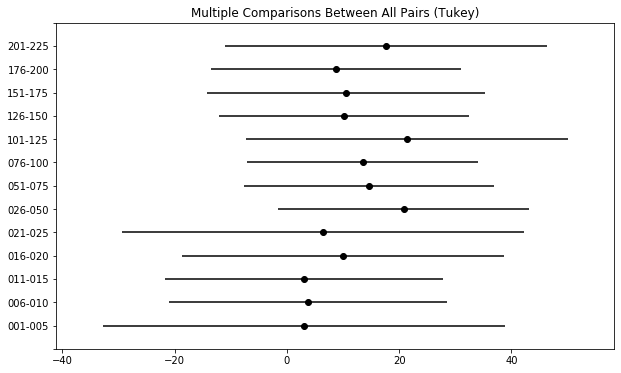

In [9]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_str = pairwise_tukeyhsd(dfp['swids'],     # Data
                          groups=dfp['TOTAL_EMAILS'],   # Groups
                          alpha=0.05)          # Significance level

tukey_str.plot_simultaneous()    # Plot group confidence intervals

tukey_str.summary()              # See test summary

### Heatmap for upsell monthly to yearly subscription propensity by platform and subscription length in days to those exposed to upsell emails

In [11]:
dfp_sql = """

    SELECT distinct platform_yearly
        , SUB_START_DIFF_DAYS
        , count(distinct swid) as swids
       
        FROM test
        
        GROUP BY 
            platform_yearly
            , SUB_START_DIFF_DAYS; """

dfp_corr = (ps.sqldf(dfp_sql, locals()))
dfp_corr.head(5)

,PLATFORM_YEARLY,SUB_START_DIFF_DAYS,swids
0,AMAZON,None,16627
1,AMAZON,001-050,13815
2,AMAZON,051-100,6963
3,AMAZON,101-150,6037
4,AMAZON,151-200,4974


In [12]:
dfp_corr2 = dfp_corr.pivot(index='PLATFORM_YEARLY', columns='SUB_START_DIFF_DAYS', values='swids')
dfp_corr2.head(10)

SUB_START_DIFF_DAYS,nan,001-050,051-100,101-150,151-200,201-250,251-300,301-350,351-400,401-450,451-500,501-600
PLATFORM_YEARLY,,,,,,,,,,,,
AMAZON,16627.0,13815.0,6963.0,6037.0,4974.0,3877.0,3803.0,3441.0,3040.0,2377.0,1708.0,88.0
APPLE,48310.0,41048.0,18925.0,15790.0,14713.0,13114.0,13468.0,12958.0,11854.0,9166.0,6673.0,866.0
BAMTECH,176212.0,156035.0,73376.0,52178.0,47921.0,41917.0,46923.0,57595.0,51054.0,47053.0,45898.0,8934.0
BRADESCO_BANK_BR,2327.0,1341.0,256.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,NaN,NaN
BRADESCO_NEXT_BR,973.0,820.0,130.0,5.0,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN
GLOBO_BR,201.0,3611.0,1947.0,669.0,7.0,15.0,11.0,17.0,23.0,5.0,4.0,NaN
GOOGLE,28893.0,38105.0,21126.0,16453.0,13583.0,9966.0,10850.0,10997.0,8096.0,7147.0,6295.0,928.0
NO_PAYMENT,248.0,275.0,237.0,97.0,126.0,197.0,402.0,221.0,130.0,101.0,35.0,3.0
ROKU,11590.0,8533.0,6189.0,6453.0,5575.0,4436.0,4400.0,4067.0,4135.0,3409.0,2743.0,123.0


[Text(0.5, 0, 'nan'),
 Text(1.5, 0, '001-050'),
 Text(2.5, 0, '051-100'),
 Text(3.5, 0, '101-150'),
 Text(4.5, 0, '151-200'),
 Text(5.5, 0, '201-250'),
 Text(6.5, 0, '251-300'),
 Text(7.5, 0, '301-350'),
 Text(8.5, 0, '351-400'),
 Text(9.5, 0, '401-450'),
 Text(10.5, 0, '451-500'),
 Text(11.5, 0, '501-600')]

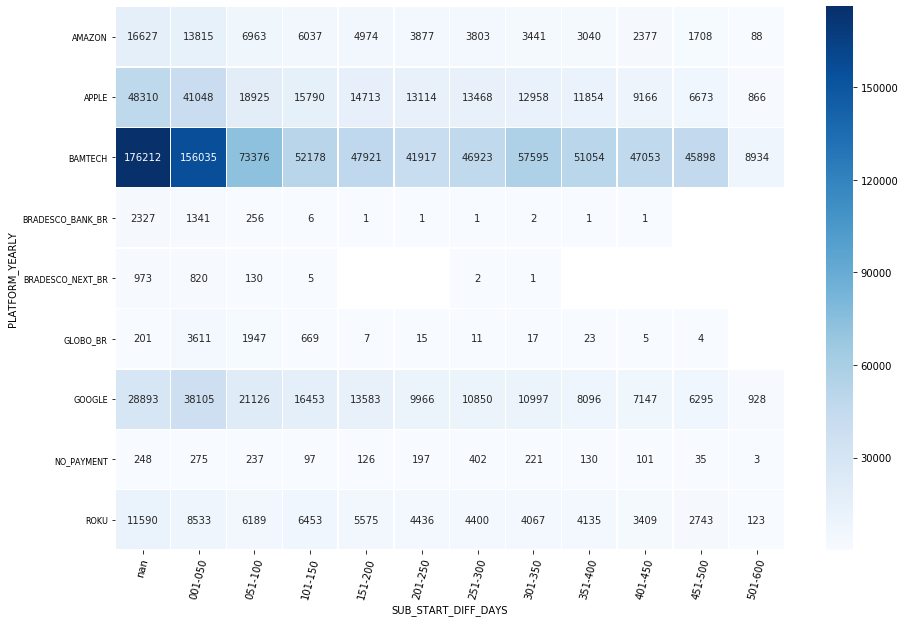

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(dfp_corr2, annot=True, linewidths=.5, cmap='Blues', fmt='g')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)

### Heatmap for upsell monthly to yearly subscription propensity by platform and email last click to those exposed to upsell emails

In [15]:
dfe_sql = """

    SELECT distinct platform_yearly
        , SUB_START_EMAIL_CLICK_DIFF_DAYS
        , count(distinct swid) as swids
       
        FROM test
        WHERE SUB_START_EMAIL_CLICK_DIFF_DAYS is not null
        
        GROUP BY 
            platform_yearly
            , SUB_START_EMAIL_CLICK_DIFF_DAYS; """

dfe_corr = (ps.sqldf(dfe_sql, locals()))
dfe_corr.head()

,PLATFORM_YEARLY,SUB_START_EMAIL_CLICK_DIFF_DAYS,swids
0,AMAZON,001-005,5
1,AMAZON,016-020,3
2,AMAZON,026-050,7
3,AMAZON,051-075,5
4,AMAZON,076-100,3


In [16]:
dfe_corr2 = dfe_corr.pivot(index='PLATFORM_YEARLY', columns='SUB_START_EMAIL_CLICK_DIFF_DAYS', values='swids')
dfe_corr2.head(10)

SUB_START_EMAIL_CLICK_DIFF_DAYS,001-005,006-010,011-015,016-020,021-025,026-050,051-075,076-100,101-125,126-150,151-175,176-200,201-225
PLATFORM_YEARLY,,,,,,,,,,,,,
AMAZON,5.0,NaN,NaN,3.0,NaN,7.0,5.0,3.0,4.0,3.0,2.0,NaN,1.0
APPLE,4.0,NaN,5.0,4.0,2.0,17.0,7.0,9.0,6.0,4.0,2.0,2.0,1.0
BAMTECH,186.0,20.0,13.0,19.0,21.0,74.0,82.0,70.0,76.0,63.0,57.0,37.0,26.0
GOOGLE,11.0,5.0,2.0,5.0,1.0,7.0,10.0,8.0,8.0,4.0,11.0,5.0,NaN
NO_PAYMENT,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
ROKU,2.0,2.0,1.0,2.0,2.0,6.0,5.0,2.0,3.0,3.0,3.0,1.0,1.0


[Text(0.5, 0, '001-005'),
 Text(1.5, 0, '006-010'),
 Text(2.5, 0, '011-015'),
 Text(3.5, 0, '016-020'),
 Text(4.5, 0, '021-025'),
 Text(5.5, 0, '026-050'),
 Text(6.5, 0, '051-075'),
 Text(7.5, 0, '076-100'),
 Text(8.5, 0, '101-125'),
 Text(9.5, 0, '126-150'),
 Text(10.5, 0, '151-175'),
 Text(11.5, 0, '176-200'),
 Text(12.5, 0, '201-225')]

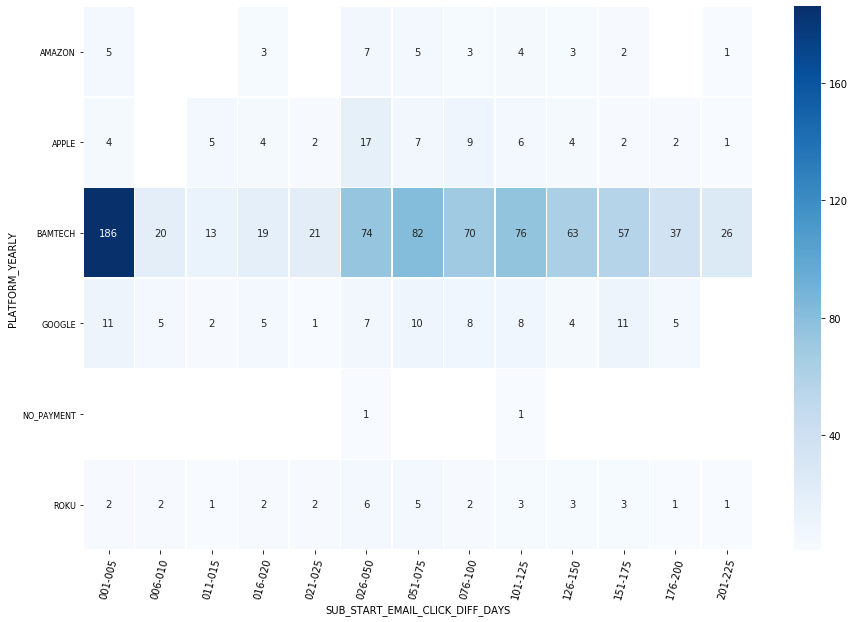

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(dfe_corr2, annot=True, linewidths=.5, cmap='Blues', fmt='g')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)

### Heatmap for upsell monthly to yearly subscription propensity by number of unique emails and email last click to those exposed to upsell emails

In [18]:
dfe2_sql = """

    SELECT distinct TOTAL_EMAILS
        , SUB_START_DIFF_DAYS
        , count(distinct SWID) as swids
       
        FROM test
        WHERE SUB_START_DIFF_DAYS is not null
        AND TOTAL_EMAILS is not null
        
        GROUP BY 
            TOTAL_EMAILS
            , SUB_START_DIFF_DAYS; """

dfe2_corr = (ps.sqldf(dfe2_sql, locals()))
dfe2_corr.head()

,TOTAL_EMAILS,SUB_START_DIFF_DAYS,swids
0,001-005,001-050,1
1,001-005,151-200,1
2,001-005,201-250,1
3,001-005,301-350,1
4,001-005,351-400,1


In [19]:
dfe2_corr2 = dfe2_corr.pivot(index='TOTAL_EMAILS', columns='SUB_START_DIFF_DAYS', values='swids')
dfe2_corr2.head(50)

SUB_START_DIFF_DAYS,001-050,051-100,101-150,151-200,201-250,251-300,301-350,351-400,401-450,451-500,501-600
TOTAL_EMAILS,,,,,,,,,,,
001-005,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN
006-010,NaN,4.0,1.0,2.0,3.0,2.0,3.0,1.0,2.0,2.0,1.0
011-015,1.0,3.0,1.0,2.0,1.0,NaN,3.0,1.0,4.0,NaN,NaN
016-020,2.0,1.0,5.0,5.0,3.0,4.0,6.0,3.0,2.0,7.0,1.0
021-025,1.0,1.0,2.0,2.0,1.0,NaN,1.0,1.0,3.0,2.0,1.0
026-050,2.0,7.0,8.0,15.0,15.0,15.0,14.0,12.0,15.0,16.0,2.0
051-075,4.0,5.0,7.0,11.0,10.0,8.0,14.0,11.0,5.0,9.0,1.0
076-100,7.0,10.0,9.0,15.0,14.0,12.0,13.0,8.0,3.0,10.0,NaN
101-125,4.0,7.0,9.0,17.0,4.0,13.0,8.0,7.0,3.0,7.0,2.0


[Text(0.5, 0, '001-050'),
 Text(1.5, 0, '051-100'),
 Text(2.5, 0, '101-150'),
 Text(3.5, 0, '151-200'),
 Text(4.5, 0, '201-250'),
 Text(5.5, 0, '251-300'),
 Text(6.5, 0, '301-350'),
 Text(7.5, 0, '351-400'),
 Text(8.5, 0, '401-450'),
 Text(9.5, 0, '451-500'),
 Text(10.5, 0, '501-600')]

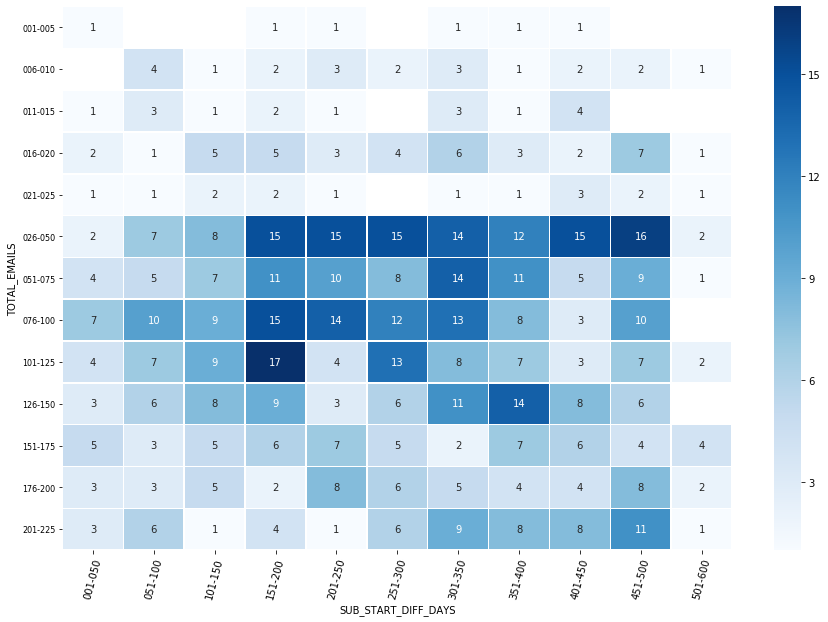

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(dfe2_corr2, annot=True, linewidths=.5, cmap='Blues', fmt='g')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)

### Heatmap for upsell monthly to yearly subscription propensity by number of unique emails per platform and email last click to those exposed to upsell emails

In [22]:
dfpe_sql = """

    SELECT distinct PLATFORM_EMAILS
        , SUB_START_DIFF_DAYS
        , count(distinct SWID) as swids
       
        FROM test
        WHERE SUB_START_DIFF_DAYS is not null
        AND TOTAL_EMAILS is not null
        
        GROUP BY 
            PLATFORM_EMAILS
            , SUB_START_DIFF_DAYS; """

dfpe_corr = (ps.sqldf(dfpe_sql, locals()))
dfpe_corr.head()

,PLATFORM_EMAILS,SUB_START_DIFF_DAYS,swids
0,001-005_AMAZON,151-200,1
1,001-005_AMAZON,351-400,1
2,001-005_BAMTECH,001-050,1
3,001-005_BAMTECH,201-250,1
4,001-005_BAMTECH,301-350,1


In [23]:
dfpe_corr2 = dfpe_corr.pivot(index='PLATFORM_EMAILS', columns='SUB_START_DIFF_DAYS', values='swids')
dfpe_corr2.head(100)

SUB_START_DIFF_DAYS,001-050,051-100,101-150,151-200,201-250,251-300,301-350,351-400,401-450,451-500,501-600
PLATFORM_EMAILS,,,,,,,,,,,
001-005_AMAZON,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
001-005_BAMTECH,1.0,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,NaN
006-010_AMAZON,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006-010_APPLE,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
006-010_BAMTECH,NaN,1.0,1.0,1.0,2.0,NaN,2.0,1.0,2.0,2.0,NaN
006-010_GOOGLE,NaN,2.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,1.0
011-015_AMAZON,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
011-015_APPLE,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
011-015_BAMTECH,NaN,2.0,NaN,1.0,1.0,NaN,1.0,1.0,4.0,NaN,NaN


[Text(0.5, 0, '001-050'),
 Text(1.5, 0, '051-100'),
 Text(2.5, 0, '101-150'),
 Text(3.5, 0, '151-200'),
 Text(4.5, 0, '201-250'),
 Text(5.5, 0, '251-300'),
 Text(6.5, 0, '301-350'),
 Text(7.5, 0, '351-400'),
 Text(8.5, 0, '401-450'),
 Text(9.5, 0, '451-500'),
 Text(10.5, 0, '501-600')]

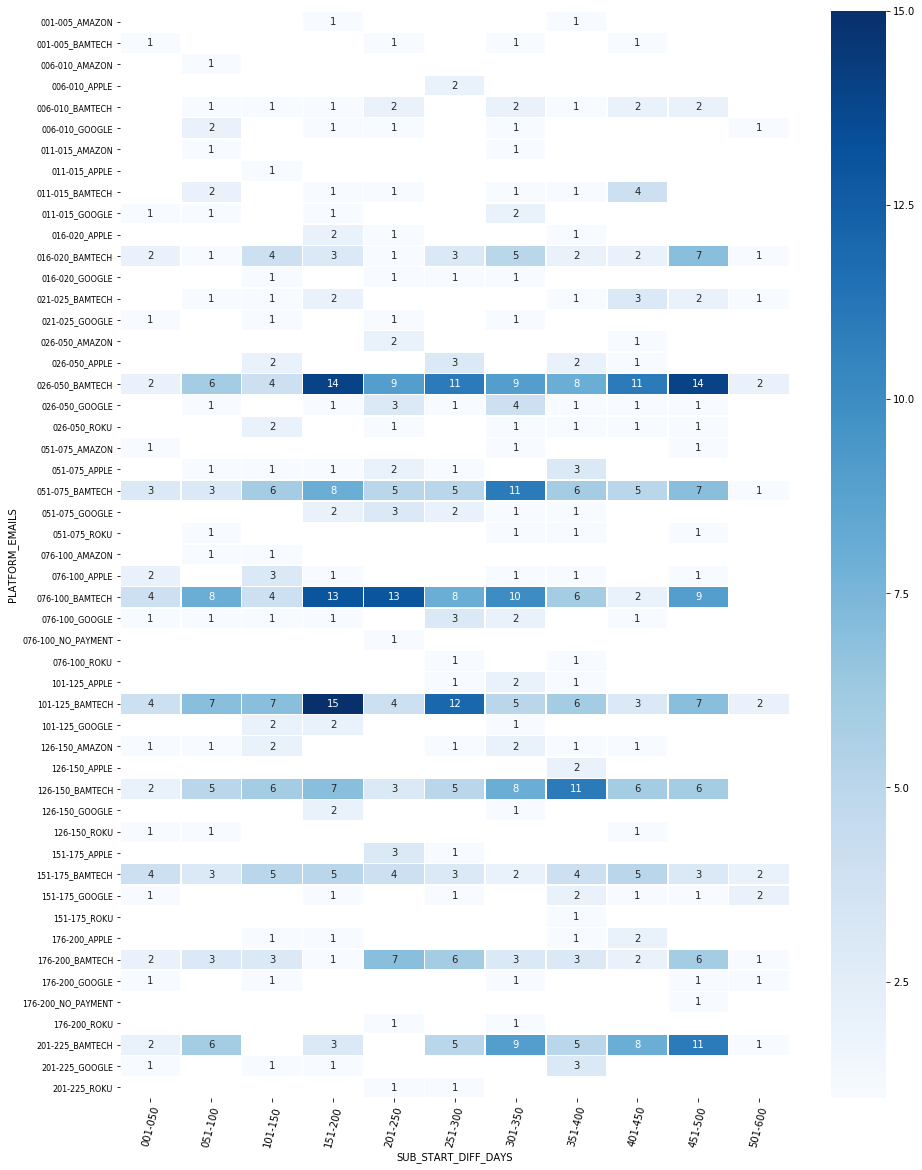

In [24]:
fig, ax = plt.subplots(figsize=(15,20))
ax = sns.heatmap(dfpe_corr2, annot=True, linewidths=.5, cmap='Blues', fmt='g')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)